In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path

from matplotlib import ticker, transforms
from mpl_axes_aligner import align
import matplotlib.pyplot as plt

In [2]:
api_key = 'N6sTD5Jriyd5fxO8Y19Dzw'
cases = 'corrected_covid_positive'

In [3]:
def query(sql, **kw):
    response = requests.get('https://joinzoe.carto.com/api/v2/sql/', params={
        'q':sql,
        'api_key':api_key
    })
    data = response.json()
    if 'error' in data:
        return data['error']
    return pd.DataFrame.from_records(data['rows'], **kw)

In [4]:
def pickle(df, name, for_date):
    path = f'~/Downloads/zoe_{name}_{for_date:%Y-%m-%d}_{datetime.now():%Y-%m-%d-%H-%M}.pickle'
    df.to_pickle(path)
    return path

In [5]:
tables = query("SELECT * FROM pg_catalog.pg_tables where tableowner!='postgres' order by tablename")
tables

['system tables are forbidden']

In [6]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index)

In [7]:
curr_date = uk_active_cases.index.max()
curr_est = uk_active_cases['corrected_covid_positive'].iloc[-1]
pickle(uk_active_cases, 'uk_active_cases', curr_date)

'~/Downloads/zoe_uk_active_cases_2020-08-05_2020-08-07-10-47.pickle'

In [8]:
prev_date = curr_date.date()
while True:
    prev_date -= timedelta(days=1)
    prev_uk_active_cases_glob = f'zoe_uk_active_cases_{prev_date}*'
    prev_uk_active_cases_paths = sorted(Path('~/Downloads/').expanduser().glob(prev_uk_active_cases_glob), reverse=True)
    if prev_uk_active_cases_paths:
        prev_uk_active_cases_path = prev_uk_active_cases_paths[0]
        break

prev_uk_active_cases = pd.read_pickle(prev_uk_active_cases_path)
prev_uk_active_cases_path

PosixPath('/Users/chris/Downloads/zoe_uk_active_cases_2020-08-03_2020-08-04-17-33.pickle')

In [9]:
prev_data_end = prev_date+timedelta(days=1)
diff = uk_active_cases[cases].sub(prev_uk_active_cases[cases], fill_value=0)
diff[prev_data_end:] = uk_active_cases[cases].diff()[prev_data_end:]

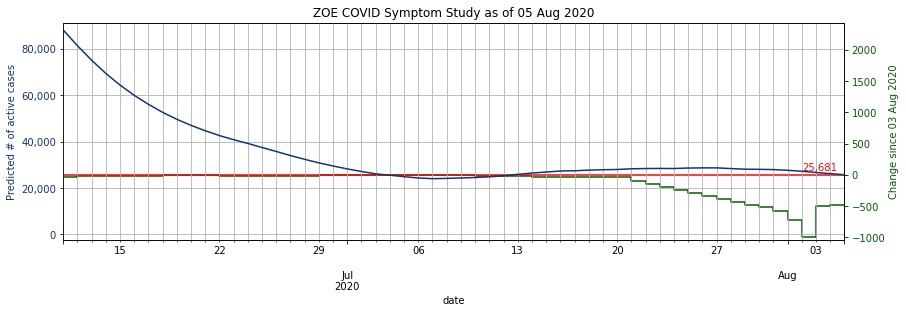

In [10]:
month_ago = datetime.now().date()-timedelta(days=30)
start = min(month_ago, diff.index.min()-timedelta(days=7))

data_colour = '#113377'
diff_colour = '#015c00'
curr_colour = 'red'
fig, ax = plt.subplots(figsize=(14, 4))
fig.set_facecolor('white')

data_to_plot = uk_active_cases[cases][start:]
data_to_plot.plot(ax=ax, grid=True, color=data_colour)
ax.set_title(f'ZOE COVID Symptom Study as of {curr_date:%d %b %Y}')
ax.xaxis.grid(True, which='minor')
ax.tick_params(axis='y', labelcolor=data_colour)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('Predicted # of active cases', color=data_colour)

ax.axhline(y=curr_est, color=curr_colour, zorder=-100)
trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(1, curr_est+1000, "{:,.0f}".format(curr_est), color=curr_colour, transform=trans, 
        ha="right", va="bottom", zorder=1000)
ax.patch.set_visible(False)

diff_ax = ax.twinx()
diff_ax.set_zorder(-1)
diff_ax.tick_params(axis='y', labelcolor=diff_colour)
diff_ax.set_ylabel(f'Change since {prev_date:%d %b %Y}', color=diff_colour)
diff_to_plot = diff.loc[start:].reindex(data_to_plot.index)
_ = diff_to_plot.plot(ax=diff_ax, drawstyle='steps', color=diff_colour, zorder=-1)
    
align.yaxes(ax, curr_est, diff_ax, 0, 0.3)

In [11]:
data_index = []
data_values = []
stop_path = sorted(Path('~/Downloads/').expanduser().glob(f'zoe_uk_active_cases_*'))[0]
stop_date = pd.to_datetime(stop_path.name.rsplit('_', 1)[0], format='zoe_uk_active_cases_%Y-%m-%d').date()
point_path = None
point_date = curr_date.date()
while point_date > stop_date:
    point_glob = f'zoe_uk_active_cases_{point_date}*'
    point_paths = sorted(Path('~/Downloads/').expanduser().glob(point_glob), reverse=True)
    if point_paths:
        point_path = point_paths[0]
        point_df = pd.read_pickle(point_path)
        point_data = point_df.iloc[-1]
        data_index.append(point_data.name)
        data_values.append(point_data.corrected_covid_positive)
    point_date -= timedelta(days=1)

In [12]:
stop_path = sorted(Path('~/Downloads/').expanduser().glob(f'zoe_uk_time_series_*'))[0]
stop_date = pd.to_datetime(stop_path.name.rsplit('_', 1)[0], format='zoe_uk_time_series_%Y-%m-%d').date()
point_path = None
point_date = curr_date.date()
while point_date > stop_date:
    point_glob = f'zoe_uk_time_series_{point_date}*'
    point_paths = sorted(Path('~/Downloads/').expanduser().glob(point_glob), reverse=True)
    if point_paths:
        point_path = point_paths[0]
        point_df = pd.read_pickle(point_path)
        point_data = point_df.iloc[-1]
        data_index.append(point_data.name.tz_localize(None))
        data_values.append(point_data.corrected_covid_positive*1000000)
    point_date -= timedelta(days=1)

In [13]:
predictions_on_date = pd.Series(data_values, pd.DatetimeIndex(data_index)).sort_index()

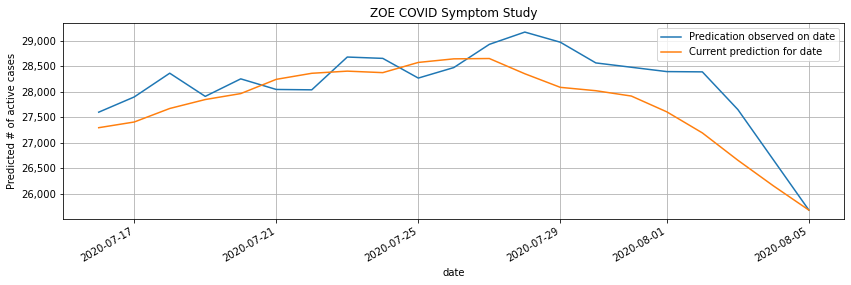

In [14]:
cut_off = curr_date-timedelta(days=20)
fig, ax = plt.subplots(figsize=(14, 4))
fig.set_facecolor('white')

predictions_on_date[cut_off:].plot(label='Predication observed on date')
data_to_plot[cut_off:].plot(label='Current prediction for date')
plt.grid()

ax.set_title(f'ZOE COVID Symptom Study')
ax.xaxis.grid(True, which='minor')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('Predicted # of active cases')
plt.legend()

In [15]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)
prevalence_map

,cartodb_id,the_geom,the_geom_webmercator,objectid,lad16cd,lad16nm,lad16nmw,bng_e,bng_n,long,...,corrected_covid_positive,cases_pm,percentage,discrete_percentage,discrete_cases_pm,percentage_string,cases_pm_string,data_status,country,region
0,14077,0103000020E610000001000000C4010000AD9CD15F9CE2...,0103000020110F000001000000C40100000AEC1A1775E3...,1,E06000001,Hartlepool,None,447157,531476,-1.27023,...,0.000000,0,0.000000,0.00,0,0.0 %,0,05:00:02 06-08-2020,England,North East
1,14089,0106000020E61000000300000001030000000100000004...,0106000020110F00000300000001030000000100000004...,13,E06000013,North Lincolnshire,None,497798,410996,-0.52410,...,95.097869,1175.75,0.117575,0.10,1000,0.1 %,1176,05:00:02 06-08-2020,England,Yorkshire and The Humber
2,14078,0106000020E61000000200000001030000000100000013...,0106000020110F00000200000001030000000100000013...,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,...,72.208045,1500.99,0.150099,0.10,1000,0.2 %,1501,05:00:02 06-08-2020,England,North East
3,14079,0106000020E61000000200000001030000000100000006...,0106000020110F00000200000001030000000100000006...,3,E06000003,Redcar and Cleveland,None,464359,519597,-1.00611,...,0.000000,0,0.000000,0.00,0,0.0 %,0,05:00:02 06-08-2020,England,North East
4,14080,0106000020E61000000200000001030000000100000025...,0106000020110F00000200000001030000000100000025...,4,E06000004,Stockton-on-Tees,None,444937,518183,-1.30669,...,98.369599,1013.3,0.101330,0.10,1000,0.1 %,1013,05:00:02 06-08-2020,England,North East
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,14446,0106000020E610000002000000010300000001000000B0...,0106000020110F000002000000010300000001000000B0...,389,W06000022,Newport,Casnewydd,337897,187433,-2.89769,...,47.447685,542.693,0.054269,0.05,500,0.1 %,543,05:00:02 06-08-2020,Wales,Wales
387,14447,0103000020E6100000010000006D1000003E242470162E...,0103000020110F0000010000006D10000087DF530DAA62...,390,W06000023,Powys,Powys,302328,273254,-3.43533,...,23.676807,252.246,0.025225,0.01,100,0.0 %,252,05:00:02 06-08-2020,Wales,Wales
388,14448,0103000020E61000000100000060010000CAAE459CF9AC...,0103000020110F0000010000006001000038E916C4D9A7...,391,W06000024,Merthyr Tydfil,Merthyr Tudful,305916,206424,-3.36425,...,12.643690,370.012,0.037001,0.01,100,0.0 %,370,05:00:02 06-08-2020,Wales,Wales
389,14449,0103000020E610000001000000C0000000CA21EFF2CDF8...,0103000020110F000001000000C0000000F7A9DBECED86...,325,E09000032,Wandsworth,None,525152,174137,-0.20021,...,111.191642,437.768,0.043777,0.01,100,0.0 %,438,05:00:02 06-08-2020,England,London


In [16]:
for_date, = prevalence_map['data_status'].unique()
pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y'))

'~/Downloads/zoe_prevalence_map_2020-08-06_2020-08-07-10-47.pickle'

In [17]:
prevalence_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cartodb_id                      391 non-null    int64  
 1   the_geom                        391 non-null    object 
 2   the_geom_webmercator            391 non-null    object 
 3   objectid                        391 non-null    int64  
 4   lad16cd                         391 non-null    object 
 5   lad16nm                         391 non-null    object 
 6   lad16nmw                        22 non-null     object 
 7   bng_e                           391 non-null    int64  
 8   bng_n                           391 non-null    int64  
 9   long                            391 non-null    float64
 10  lat                             391 non-null    float64
 11  st_areasha                      391 non-null    float64
 12  st_lengths                      391 

In [18]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
170,Hyndburn,E07000120,0.450160
7,Halton,E06000006,0.379669
256,Shetland Islands,S12000027,0.351192
236,City of London,E09000001,0.313156
152,Selby,E07000169,0.263223
193,Great Yarmouth,E07000145,0.259466
117,Castle Point,E07000069,0.256924
53,Luton,E06000032,0.245376
10,Blackburn with Darwen,E06000008,0.233306
309,St. Helens,E08000013,0.226958


In [19]:
import geopandas
import shapely
from geopandas import GeoDataFrame
import glob
from pathlib import Path
from dateutil.parser import parse as parse_date

In [20]:
def convert_df(df, geom_col):
    geoms = df[geom_col]
    df[geom_col] = geoms = geoms.apply(lambda x: shapely.wkb.loads(str(x), hex=True))
    crs = "epsg:{}".format(shapely.geos.lgeos.GEOSGetSRID(geoms.iat[0]._geom))
    return GeoDataFrame(df, crs=crs, geometry=geom_col)

Text(0.5, 1.0, 'ZOE COVID Symptom Study data for 06 Aug 2020')

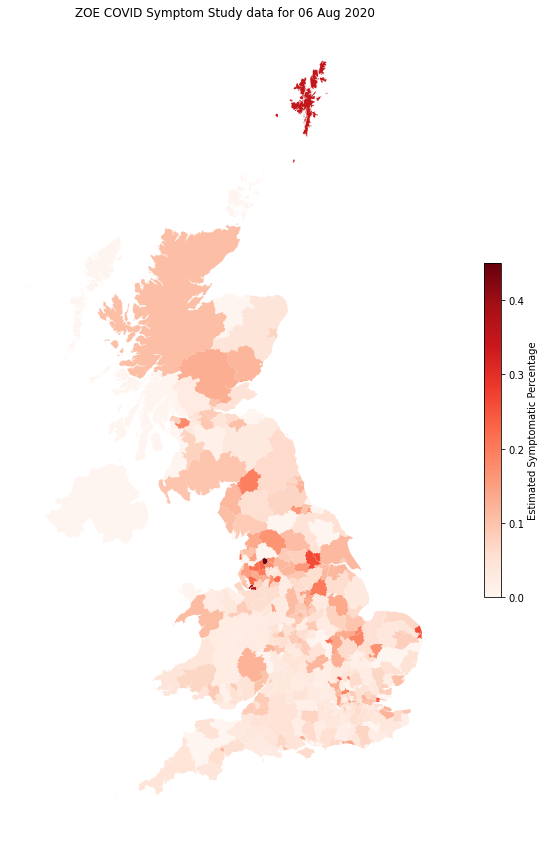

In [31]:
path = sorted(Path('~/Downloads/').expanduser().glob(f'zoe_prevalence_map_*.pickle'), reverse=True)[0]
date = parse_date(str(path).rsplit('_')[-2]).date()
df = pd.read_pickle(path)
gdf = convert_df(df, 'the_geom_webmercator')
ax = gdf.plot(
    column='percentage', 
    k=10, figsize=(15, 15), 
    cmap='Reds', 
    legend=True, 
    legend_kwds={'fraction': 0.02, 'anchor': (0, 0), 'label': 'Estimated Symptomatic Percentage'},
)
ax.set_axis_off()
ax.set_title(f'ZOE COVID Symptom Study data for {date:%d %b %Y}')